In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id', encoding="ISO-8859-1")
test = pd.read_csv('./data/test.csv', index_col='id', encoding="ISO-8859-1")

products_description = pd.read_csv('./data/product_descriptions.csv')

In [3]:
# merge with product description

train = pd.merge(train, products_description, how='left', on='product_uid')
test = pd.merge(test, products_description, how='left', on='product_uid')

In [4]:
# load product attributes

attributes = pd.read_csv('./data/attributes.csv')

In [5]:
# filter out brands
attributes = attributes[attributes.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})

In [6]:
train_with_attributes = pd.merge(train, attributes, how='left', on='product_uid')
test_with_attributes = pd.merge(test, attributes, how='left', on='product_uid')

In [7]:
train_with_attributes = train_with_attributes.fillna('Unknown')
test_with_attributes = test_with_attributes.fillna('Unknown')

In [8]:
train_with_attributes.head()

,product_uid,product_title,search_term,relevance,product_description,brand
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta


In [9]:
test_with_attributes.head()

,product_uid,product_title,search_term,product_description,brand
0,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
3,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
4,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie


In [10]:
y = train_with_attributes.relevance

In [11]:
from sklearn.cross_validation import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_with_attributes, y, test_size=0.3, random_state=44)

In [13]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(51846, 6) (22221, 6) (51846L,) (22221L,)


In [14]:
# import external scripts
%run scripts/features.py
%run scripts/models.py

In [15]:
# for rmse
from sklearn.metrics import mean_squared_error

In [16]:
# fit a model 
rf_model = build_random_forest_model()
rf_model.fit(X_train, y_train)

Pipeline(steps=[('ft', FeatureTransformer()), ('reg', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [17]:
predsTrain = rf_model.predict(X_train)
predsTest = rf_model.predict(X_test)

In [18]:
print 'RMSE on the training set %f ' %(np.sqrt(mean_squared_error(y_train, predsTrain)))
print 'RMSE on the test set %f ' %(np.sqrt(mean_squared_error(y_test, predsTest)))

RMSE on the training set 0.474861 
RMSE on the test set 0.477771 


In [ ]:
# fit on the entire training dataset
online_model_pipe.fit(train_with_attributes, y)

In [20]:
predictions = rf_model.predict(test_with_attributes)

In [21]:
def scale_predictions(prediction):
    if prediction > 3.0:
        return 3.0
    elif prediction < 1.0:
        return 1.0
    else:
        return prediction

In [ ]:
predictions = map(scale_predictions, predictions)

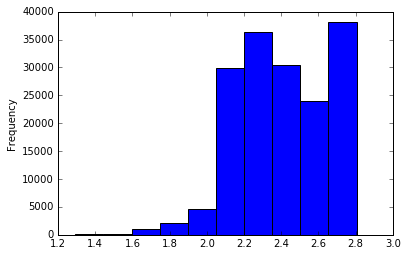

In [22]:
pd.Series(predictions).plot(kind='hist')

In [23]:
# prepare submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['relevance'] = predictions
submission.to_csv('./submissions/thirteenth.csv', index=False)